# PSF Experiment 2.0 - amc vs ngmix -  Moments + fixnoise

This notebook serves as a unit test base between amc and ngmix.

In [1]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
#os
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
#utilities
from multiprocessing import Pool
from scipy.stats import linregress
import tqdm

In [3]:
#this is us
import autometacal as amc
import tensorflow_datasets as tfds
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

#...vs them!
import ngmix
import galsim

galsimrot90 = galsim.Angle(90,galsim.AngleUnit(pi/180.))

## Settings

In [4]:
rng = np.random.RandomState(31415)

#stamp properties
stamp_size = 51
batch_size = 30
scale = 0.263
window_fwhm = 1.7
#computation settings
ncpus = 8

#test settings
g_psf =  array([0.01,0.0],dtype='float32')
noise_level = 1e-5
fixnoise = True
shapenoise = False

psf_noise_level = noise_level/1000
psf_fwhm = 0.7

#filenames
finitechoice = "amc"
results_folder = f"./"
settings_name = f"anisotropic_psf_{str(noise_level)}"

#build filename
if shapenoise:
  settings_name += "_shaped"
else:
  settings_name += "_round"
  
if fixnoise:
  settings_name += "_fixnoise"
else:
  settings_name += "_nofixnoise"  

## Create observations

In [5]:
#datasetless observer
def make_noise(noise_level,batch_size,stamp_size):
  '''make a simple gaussian noise stamp'''
  noise_imgs = np.random.normal(scale=noise_level,size=[batch_size,stamp_size,stamp_size])
  return noise_imgs

def observer(batch_size=25, 
             shear_true = [0.,0.] ,
             true_epsf = [0.,0.], 
             noise_level = 1e-6,
             shape_noise = False,
             symmetric = True,
             method ='auto'):
  '''creates observations for ngmix and amc'''
  #galaxy intrinsic properties
  gal_hlr = 0.5
  flux = 1.
  
  #psf properties
  psf_obj = galsim.Moffat(beta=4.8, fwhm=psf_fwhm).shear(g1=true_epsf[0],g2=true_epsf[1]) 
  psf_images_list = []
  gal_images_list = []
  
  for i in range(batch_size):
    #intrinsic shape
    if shape_noise:
      e=99
      while e>1:
        #throws away choices with e>1  
        e1, e2 = np.random.normal(0,.3), np.random.normal(0,.3)
        e = e1**2 + e2**2
        
      intrinsic_shape = [e1,e2]   
    else:
      intrinsic_shape = [0,0] #for the future, add shape noise
    
    obj = galsim.Exponential(half_light_radius=gal_hlr).shear(g1=intrinsic_shape[0],g2=intrinsic_shape[1])
    #shear
    obj = obj.shear(g1=shear_true[0] ,g2=shear_true[1] )
    #convolve
    obj = galsim.Convolve([obj,psf_obj])
    #draw
    gal_image = obj.drawImage(nx=stamp_size, ny=stamp_size, scale=scale,method=method).array
    psf_image = psf_obj.drawImage(nx=stamp_size, ny=stamp_size, scale=scale,method=method).array
    
    psf_images_list += [psf_image]
    gal_images_list += [gal_image]
  
  psf_images = tf.convert_to_tensor(array(psf_images_list),dtype=tf.float32)
  gal_images = tf.convert_to_tensor(array(gal_images_list),dtype=tf.float32)
  
  #add noise
  noise_images = make_noise(noise_level,batch_size,stamp_size)
  gal_images += noise_images
  
  #add noise to the psf model after convolution to make it an observed model
  psf_noise_images = make_noise(psf_noise_level,batch_size,stamp_size)
  psf_images += psf_noise_images
    
  #images to be used for fixnoise are different from the
  #actual noise, but with the same level
  noise_images_out = make_noise(noise_level,batch_size,stamp_size)
  
  if symmetric:
    
    psf_images90_list = []
    gal_images90_list = []
    for i in range(batch_size):
      #use same intrinsic shape for cancelation
      obj90 = galsim.Exponential(half_light_radius=gal_hlr).shear(g1=intrinsic_shape[0],g2=intrinsic_shape[1]).rotate(galsimrot90)
      #shear
      obj90 = obj90.shear(g1=shear_true[0] ,g2=shear_true[1])
      #convolve
      obj90 = galsim.Convolve([obj90,psf_obj])
      #draw
      gal_image90 = obj90.drawImage(nx=stamp_size, ny=stamp_size, scale=scale,method=method).array
      psf_image90 = psf_obj.drawImage(nx=stamp_size, ny=stamp_size, scale=scale,method=method).array

      psf_images90_list += [psf_image90]
      gal_images90_list += [gal_image90]

    psf_images90 = tf.convert_to_tensor(array(psf_images90_list),dtype=tf.float32)
    gal_images90 = tf.convert_to_tensor(array(gal_images90_list),dtype=tf.float32)
   
    #add noise
    noise_images90 = make_noise(noise_level,batch_size,stamp_size)
    gal_images90 += noise_images90
    
    #add noise to the psf model
    psf_noise_images90 = make_noise(psf_noise_level,batch_size,stamp_size)
    psf_images90 += psf_noise_images90
    
    #images to be used for fixnoise are different from the
    #actual noise, but with the same level
    noise_images_out90 = make_noise(noise_level,batch_size,stamp_size)
    
    #concatenate symmetrised obs
    gal_images= concatenate([gal_images,gal_images90])
    psf_images = concatenate([psf_images,psf_images90])
    noise_images_out = concatenate([noise_images_out,noise_images_out90])
  
  #generate observations for ngmix
  obslist = []
  for im, psf_im in zip(gal_images,psf_images):
    cen = (array(im.shape))//2
    psf_cen = (array(psf_im.shape))//2

    jacobian = ngmix.DiagonalJacobian(
        row=cen[0], col=cen[1], scale=scale,
    )
    psf_jacobian = ngmix.DiagonalJacobian(
        row=psf_cen[0], col=psf_cen[1], scale=scale,
    )
    wt = im*0 + 1.0/noise_level**2
    psf_wt = psf_im*0 + 1.0/psf_noise_level**2

    psf_obs = ngmix.Observation(
        psf_im,
        weight=psf_wt,
        jacobian=psf_jacobian,
    )

    obs = ngmix.Observation(
        im,
        weight=wt,
        jacobian=jacobian,
        psf=psf_obs,
    )
    obslist += [obs]
  
  return gal_images, psf_images ,noise_images_out, obslist

## Make the ngmix runner

In [6]:
def ngmix_booter_moments(rng,**kwargs):
  '''create ngmix bootstraper'''
  options = {
    'psf': 'gauss',
    'types': ['noshear', 
              '1p', '1m', '2p', '2m'#, '1p_psf', '1m_psf', '2p_psf', '2m_psf'
              ],
    'scale': scale,
        
  }

  weight_fwhm = window_fwhm
  fitter = ngmix.gaussmom.GaussMom(fwhm=weight_fwhm)
  psf_fitter = ngmix.gaussmom.GaussMom(fwhm=weight_fwhm)

  # these "runners" run the measurement code on observations
  psf_runner = ngmix.runners.PSFRunner(fitter=psf_fitter)
  runner = ngmix.runners.Runner(fitter=fitter)
 
  boot = ngmix.metacal.MetacalBootstrapper(
      runner=runner,
      psf_runner=psf_runner,
      rng=rng,
      psf=options['psf'],
      types=options['types'],
    fixnoise = fixnoise
  )
  return boot

boot = ngmix_booter_moments(rng)

def ngmix_step(obs):
  '''runs 1 ngmix measurement in 1 observation'''
  resdict, _ = boot.go(obs)
  return resdict

## Extract the results

In [7]:
def get_metacal_response_ngmix_moments(resdict,shear_type = 'e',PSF=False):
  '''gets the shear response for ngmix results'''
  step=0.01
 
  #noshear
  g0s = np.array([resdict['noshear'][shear_type][0], resdict['noshear'][shear_type][1]])
  
  #shear
  g1p = np.array([resdict['1p'][shear_type][0], resdict['1p'][shear_type][1]])
  g1m = np.array([resdict['1m'][shear_type][0], resdict['1m'][shear_type][1]])
  g2p = np.array([resdict['2p'][shear_type][0], resdict['2p'][shear_type][1]])
  g2m = np.array([resdict['2m'][shear_type][0], resdict['2m'][shear_type][1]])    
  
  R11 = (g1p[0]-g1m[0])/(2*step)
  R21 = (g1p[1]-g1m[1])/(2*step) 
  R12 = (g2p[0]-g2m[0])/(2*step)
  R22 = (g2p[1]-g2m[1])/(2*step)
  
  R = np.array(
    [[R11,R12],
     [R21,R22]])
  
  if PSF:
      #PSF
      g1p_psf = np.array([resdict['1p_psf'][shear_type][0], resdict['1p_psf'][shear_type][1]])
      g1m_psf = np.array([resdict['1m_psf'][shear_type][0], resdict['1m_psf'][shear_type][1]])
      g2p_psf = np.array([resdict['2p_psf'][shear_type][0], resdict['2p_psf'][shear_type][1]])
      g2m_psf = np.array([resdict['2m_psf'][shear_type][0], resdict['2m_psf'][shear_type][1]])    

      R11_psf = (g1p_psf[0]-g1m_psf[0])/(2*step)
      R21_psf = (g1p_psf[1]-g1m_psf[1])/(2*step) 
      R12_psf = (g2p_psf[0]-g2m_psf[0])/(2*step)
      R22_psf = (g2p_psf[1]-g2m_psf[1])/(2*step)  

      ellip_dict = {
        'noshear':g0s,
        '1p':g1p,
        '1m':g1m,
        '2p':g2p,
        '2m':g2m,
        '1p_psf':g1p_psf,
        '1m_psf':g1m_psf,
        '2p_psf':g2p_psf,
        '2m_psf':g2m_psf,    
      } 
      Rpsf = np.array(
        [[R11_psf,R12_psf],
         [R21_psf,R22_psf]])
      return ellip_dict, R, Rpsf
  else:
      ellip_dict = {
        'noshear':g0s,
        '1p':g1p,
        '1m':g1m,
        '2p':g2p,
        '2m':g2m,  
      } 
      
      return ellip_dict, R, eye(2) 

In [8]:
def metacal_shear(e,R):
  return linalg.inv(R) @ e

def metacal_shear_psf(e,R,ep, Rp):
  return linalg.inv(R) @ (e - Rp @ ep)

def bootstrap(x,resample):
  return x[resample].mean(axis=0)

def evaluator(ellips, R, ellips_psf, Repsf, Rpsf):
  nboot=200 #bootstraps make it look professional
  size=ellips.shape[0]
  resample = random.randint(0,size,[nboot,size])
  
  e = bootstrap(ellips,resample).reshape(-1,2,1)
  ep = bootstrap(ellips_psf, resample).reshape(-1,2,1)
  
  
  Rep = bootstrap(Repsf, resample)
  R = bootstrap(R,resample)
  Rp = bootstrap(Rpsf,resample)
  
  #Response-calibrated shears
  shears = metacal_shear(e,R)
  shear = shears.mean(axis=0)
  shear_err = shears.std(axis=0)
  
  epsf = metacal_shear(ep.mean(axis=0),Rep.mean(axis=0))
  #PSF-corrected shears
  shearcorrs = metacal_shear_psf(e,R,epsf, Rp)
  shearcorr = shearcorrs.mean(axis=0)
  shearcorr_err = shearcorrs.std(axis=0)
  
  return shear[...,0], shear_err[...,0],  shearcorr[...,0], shearcorr_err[...,0]

## AutoMetaCal

We will run with a simple moments-based method for now.

In [9]:
#AutoMetaCal runner
@tf.function
def method(im):
  return amc.get_moment_ellipticities(im, scale=scale, fwhm=window_fwhm)

@tf.function
def response(gal_images,psf_images,noise_images):
    return amc.get_metacal_response(
      gal_images, 
      psf_images,
      psf_images,
      tf.convert_to_tensor(noise_images,dtype=tf.float32),
      method
    )


## Shakedown test

In [10]:
#batchit = data.as_numpy_iterator()
#onebatch = batchit.next()
gal_images, psf_images, noise_images, obslist = observer(shear_true=array([0.01,.0],dtype='float32'),true_epsf=g_psf,noise_level=noise_level)

In [11]:
e_amc, R_amc, Rpsf_amc, epsf_amc, Repsf_amc  = response(
  gal_images, 
  psf_images,
  tf.convert_to_tensor(noise_images,dtype=tf.float32))

/home/vitorelli/anaconda3/lib/python3.9/site-packages/tensorflow_addons/utils/resource_loader.py:78: UserWarning: You are currently using TensorFlow 2.7.0 and trying to load a custom op (custom_ops/image/_resampler_ops.so).
TensorFlow Addons has compiled its custom ops against TensorFlow 2.8.0, and there are no compatibility guarantees between the two versions. 
This means that you might get segfaults when loading the custom op, or other kind of low-level errors.
 If you do, do not file an issue on Github. This is a known limitation.

It might help you to fallback to pure Python ops by setting environment variable `TF_ADDONS_PY_OPS=1` or using `tfa.options.disable_custom_kernel()` in your code. To do that, see https://github.com/tensorflow/addons#gpucpu-custom-ops 

You can also change the TensorFlow version installed on your system. You would need a TensorFlow version equal to or above 2.8.0 and strictly below 2.9.0.
 Note that nightly versions of TensorFlow, as well as non-pip Tensor

In [12]:
shear_amc, shear_amc_err, shearcorr_amc, shearcorr_amc_err= evaluator(
  e_amc.numpy(), 
  R_amc.numpy(), 
  epsf_amc.numpy(),
  Repsf_amc.numpy(),
  Rpsf_amc.numpy()
)

In [13]:
pool = Pool(ncpus)
dlist = pool.map(ngmix_step,obslist)
pool.close()

#REXtractor (REsults eXtractor! :))
results = [get_metacal_response_ngmix_moments(resdict) for resdict in dlist]

#stack results ngmix
e_ngmix = array([result[0]['noshear'] for result in results])
R_ngmix = array([result[1] for result in results])
Rpsf_ngmix = array([result[2] for result in results])

In [14]:
shear_ngmix, shear_ngmix_err, shearcorr_ngmix, shearcorr_ngmix_err= evaluator(
  e_ngmix, 
  R_ngmix,
  array([0*g_psf for n in range(len(e_ngmix))]),
  array([eye(2) for n in range(len(e_ngmix))]),
  Rpsf_ngmix)

In [15]:
print('AutoMetaCal')
print('-------------------------------------------------')

print('With psf correction:')
print(f"g1: {shearcorr_amc[0]:.8f} +/- {shearcorr_amc_err[0]*3:.8f} (99.7%% conf)")
print(f"g2: {shearcorr_amc[1]:.8f} +/- {shearcorr_amc_err[1]*3:.8f} (99.7%% conf)")
print('-------------------------------------------------')
print('Without psf correction:')
print(f"g1: {shear_amc[0]:.8f} +/- {shear_amc_err[0]*3:.8f} (99.7%% conf)")
print(f"g2: {shear_amc[1]:.8f} +/- {shear_amc_err[1]*3:.8f} (99.7%% conf)")
print()
print('ngmix')
print('-------------------------------------------------')
print('With psf correction:')
print(f"g1: {shearcorr_ngmix[0]:.8f} +/- {shearcorr_ngmix_err[0]*3:.8f} (99.7%% conf)")
print(f"g2: {shearcorr_ngmix[1]:.8f} +/- {shearcorr_ngmix_err[1]*3:.8f} (99.7%% conf)")
print('-------------------------------------------------')
print('Without psf correction:')
print(f"g1: {shear_ngmix[0]:.8f} +/- {shear_ngmix_err[0]*3:.8f} (99.7%% conf)")
print(f"g2: {shear_ngmix[1]:.8f} +/- {shear_ngmix_err[1]*3:.8f} (99.7%% conf)")

AutoMetaCal
-------------------------------------------------
With psf correction:
g1: 0.00996222 +/- 0.00004878 (99.7%% conf)
g2: -0.00003230 +/- 0.00004382 (99.7%% conf)
-------------------------------------------------
Without psf correction:
g1: 0.01703451 +/- 0.00004849 (99.7%% conf)
g2: -0.00003184 +/- 0.00004379 (99.7%% conf)

ngmix
-------------------------------------------------
With psf correction:
g1: 0.00998135 +/- 0.00004511 (99.7%% conf)
g2: -0.00007356 +/- 0.00003978 (99.7%% conf)
-------------------------------------------------
Without psf correction:
g1: 0.00998135 +/- 0.00004511 (99.7%% conf)
g2: -0.00007356 +/- 0.00003978 (99.7%% conf)


In [16]:
print(f'bias_amc = {1-shearcorr_amc[0]/0.01:.8e} ')
print(f'bias_ngm = {1-shearcorr_ngmix[0]/0.01:.8e} ')

bias_amc = 3.77849117e-03 
bias_ngm = 1.86451116e-03 


## Many batches!

In [17]:
def run_field(shear_true,g_psf,noise_level,batches):
  '''run a single-shear field with amc and ngmix'''
  e_ngmix_list = []
  R_ngmix_list = []
  Rpsf_ngmix_list = []
  e_amc_list = []
  R_amc_list = []
  Rpsf_amc_list = []
  epsf_amc_list = []
  Repsf_amc_list = []
  
  for i in range(batches):
    #get next batch
    #onebatch = batchit.next()
    
    #make observations
    gal_images, psf_images, noise_images , obslist = observer(batch_size,shear_true,g_psf,noise_level)
    
    #run ngmix
    pool = Pool(ncpus)
    dlist = pool.map(ngmix_step,obslist)
    pool.close()

    #REXtractor (REsults eXtractor! :))
    results = [get_metacal_response_ngmix_moments(resdict) for resdict in dlist]
    
    #stack results ngmix
    e_ngmix_list += [result[0]['noshear'] for result in results]
    R_ngmix_list += [result[1] for result in results]
    Rpsf_ngmix_list += [result[2] for result in results]

    #run AutoMetaCal
    e_amc, R_amc, Rpsf_amc, epsf_amc, Repsf_amc  = response(
      gal_images, 
      psf_images,
      tf.convert_to_tensor(noise_images,dtype=tf.float32))
    
    #stack results amc
    e_amc_list += [e_amc]
    epsf_amc_list += [epsf_amc]
    R_amc_list +=[R_amc]
    Rpsf_amc_list += [Rpsf_amc]
    Repsf_amc_list += [Repsf_amc]
  
  #gather multiple ngmix batches
  e_ngmix = array(e_ngmix_list)
  R_ngmix = array(R_ngmix_list)
  epsf_ngmix = array([0*g_psf for n in range(len(e_ngmix))])
  Repsf_ngmix = array([eye(2) for n in range(len(e_ngmix))])
  Rpsf_ngmix = array(Rpsf_ngmix_list)
  
  #evaluate ngmix
  shear_ngmix, shear_err_ngmix, shearcorr_ngmix, shearcorr_err_ngmix= evaluator(
    e_ngmix, 
    R_ngmix,
    epsf_ngmix,
    Repsf_ngmix,
    Rpsf_ngmix
  )  
  
  #gather multiple amc batches
  e_amc = tf.concat(e_amc_list,axis=0)
  R_amc = tf.concat(R_amc_list,axis=0)
  epsf_amc =tf.concat(epsf_amc_list,axis=0)
  Rpsf_amc = tf.concat(Rpsf_amc_list,axis=0)
  Repsf_amc = tf.concat(Repsf_amc_list,axis=0)
  
  #evaluate amc
  shear_amc, shear_amc_err, shearcorr_amc, shearcorr_amc_err= evaluator(
    e_amc.numpy(), 
    R_amc.numpy(), 
    epsf_amc.numpy(),
    Repsf_amc.numpy(), 
    Rpsf_amc.numpy()
  ) 
  
  result_ngmix = {
    'e':e_ngmix,
    'R':R_ngmix,
    'Rpsf':Rpsf_ngmix, 
    'shear':shear_ngmix, 
    'shear_err':shear_err_ngmix, 
    'shearcorr':shearcorr_ngmix, 
    'shearcorr_err':shearcorr_err_ngmix, 
  }
  
  result_amc = {
    'e':e_amc,
    'R':R_amc,
    'Rpsf':Rpsf_amc, 
    'shear':shear_amc, 
    'shear_err':shear_amc_err, 
    'shearcorr':shearcorr_amc, 
    'shearcorr_err':shearcorr_amc_err, 
  }
 
  result = {
    'ngmix' : result_ngmix,
    'amc' : result_amc
  }
  
  return result

In [18]:
shear_range = linspace(-.01,.01,5)

shear_ngmix_list = []
shear_err_ngmix_list = []
shearcorr_ngmix_list = []
shearcorr_err_ngmix_list = []
R_ngmix_list = []
Rpsf_ngmix_list = []

shear_amc_list = []
shear_err_amc_list = []
shearcorr_amc_list = []
shearcorr_err_amc_list = []
R_amc_list = []
Rpsf_amc_list = []

for shear in tqdm.tqdm(shear_range):
  shear_true = array([shear,0.],dtype='float32')
  result = run_field(shear_true,g_psf,noise_level,20)
  #ngmix
  shear_ngmix_list += [result['ngmix']['shear'] ] 
  shear_err_ngmix_list += [result['ngmix']['shear_err']]
  shearcorr_ngmix_list += [result['ngmix']['shearcorr']]
  shearcorr_err_ngmix_list += [result['ngmix']['shearcorr_err']]
  R_ngmix_list += [result['ngmix']['R']]
  Rpsf_ngmix_list += [result['ngmix']['Rpsf']]
  #amc   
  shear_amc_list += [result['amc']['shear']]
  shear_err_amc_list += [result['amc']['shear_err']]
  shearcorr_amc_list += [result['amc']['shearcorr']]
  shearcorr_err_amc_list += [result['amc']['shearcorr_err']]
  R_amc_list += [result['amc']['R']]
  Rpsf_amc_list += [result['amc']['Rpsf']]
  

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [07:41<00:00, 92.38s/it]


## Gather Results

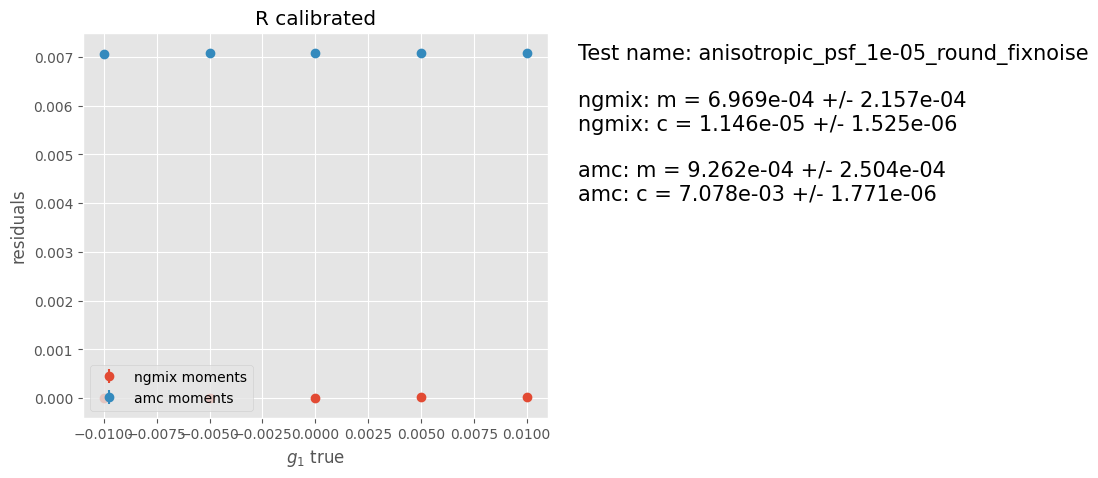

In [19]:
style.use('ggplot')
figure(figsize=(6,5))

X1 = shear_range
Y1 =  array(shear_ngmix_list)[:,0]
Y1err = array(shear_err_ngmix_list)[:,0]

#biases
ngmix_bias = linregress(X1,Y1)
m_ngmix = ngmix_bias.slope-1
c_ngmix = ngmix_bias.intercept

#errors
m_ngmix_err = ngmix_bias.stderr
c_ngmix_err = ngmix_bias.intercept_stderr

plot_text = f"Test name: {settings_name}\n\n"

plot_text +=  f"ngmix: m = {m_ngmix:.3e} +/- {m_ngmix_err:.3e}\n"
plot_text += f"ngmix: c = {c_ngmix:.3e} +/- {c_ngmix_err:.3e}\n"

errorbar(X1,Y1 - X1,Y1err*3,fmt='o',label= 'ngmix moments')

Y1 =  array(shear_amc_list)[:,0] 
Y1err = array(shear_err_amc_list)[:,0]

#biases
amc_bias = linregress(X1,Y1)
m_amc = amc_bias.slope-1
c_amc = amc_bias.intercept

#errors
m_amc_err = amc_bias.stderr
c_amc_err = amc_bias.intercept_stderr

errorbar(X1,Y1 - X1,Y1err*3,fmt='o',label= 'amc moments')

plot_text += f"\namc: m = {m_amc:.3e} +/- {m_amc_err:.3e}\n"
plot_text += f"amc: c = {c_amc:.3e} +/- {c_amc_err:.3e}\n"

figtext(.95,.5 ,plot_text,fontsize=15)

xlabel('$g_1$ true')
ylabel('residuals')

legend(loc=3)
title(f'R calibrated')
savefig(f'uncorrected_shear_residuals_{settings_name}.jpg',bbox_inches='tight')

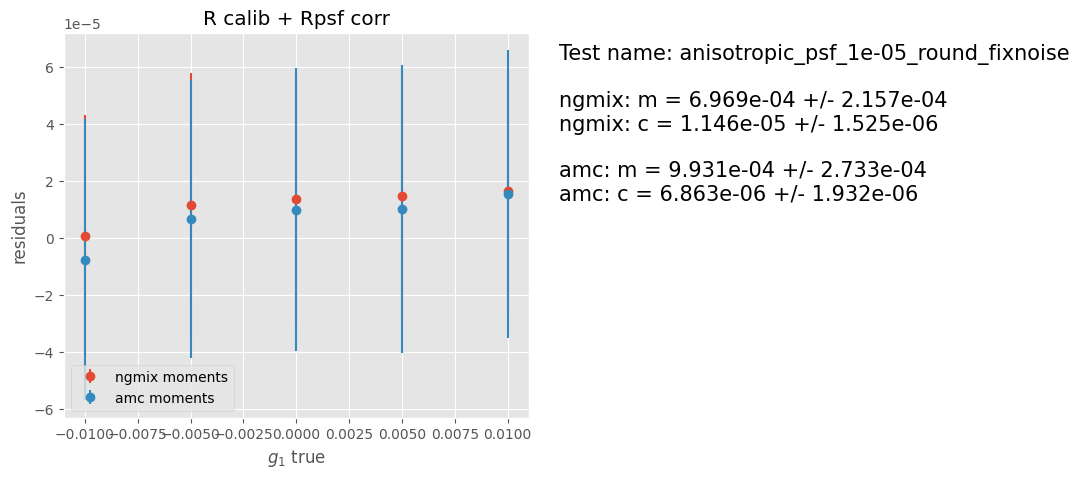

In [20]:
style.use('ggplot')
figure(figsize=(6,5))

X1 = shear_range
Y1 =  array(shearcorr_ngmix_list)[:,0]
Y1err = array(shearcorr_err_ngmix_list)[:,0]

#biases
ngmix_bias = linregress(X1,Y1)
m_ngmix = ngmix_bias.slope - 1
c_ngmix = ngmix_bias.intercept

#errors
m_ngmix_err = ngmix_bias.stderr
c_ngmix_err = ngmix_bias.intercept_stderr

plot_text = f"Test name: {settings_name}\n\n"
plot_text +=  f"ngmix: m = {m_ngmix:.3e} +/- {m_ngmix_err:.3e}\n"
plot_text += f"ngmix: c = {c_ngmix:.3e} +/- {c_ngmix_err:.3e}\n"

errorbar(X1,Y1 - X1,Y1err*3,fmt='o',label= 'ngmix moments')

Y1 =  array(shearcorr_amc_list)[:,0] 
Y1err = array(shearcorr_err_amc_list)[:,0]

#biases
amc_bias = linregress(X1,Y1)
m_amc = amc_bias.slope-1
c_amc = amc_bias.intercept

#errors
m_amc_err = amc_bias.stderr
c_amc_err = amc_bias.intercept_stderr

errorbar(X1,Y1 - X1,Y1err*3,fmt='o',label= 'amc moments')

plot_text += f"\namc: m = {m_amc:.3e} +/- {m_amc_err:.3e}\n"
plot_text += f"amc: c = {c_amc:.3e} +/- {c_amc_err:.3e}\n"

figtext(.95,.5 ,plot_text,fontsize=15)

xlabel('$g_1$ true')
ylabel('residuals')

legend(loc=3)
title(f'R calib + Rpsf corr')
savefig(f'corrected_shear_residuals_{settings_name}.jpg',bbox_inches='tight')

In [21]:
R_amc = result['amc']['R']
R_ngmix = result['ngmix']['R']
Rpsf_amc =result['amc']['Rpsf']
Rpsf_ngmix = result['ngmix']['Rpsf']

In [22]:
R_amc = tf.concat(R_amc_list,axis=0)
R_ngmix = tf.cast(tf.concat(R_ngmix_list,axis=0),dtype=tf.float32)
Rpsf_amc =tf.concat(Rpsf_amc_list,axis=0)
Rpsf_ngmix = tf.cast(tf.concat(Rpsf_ngmix_list,axis=0),dtype=tf.float32)

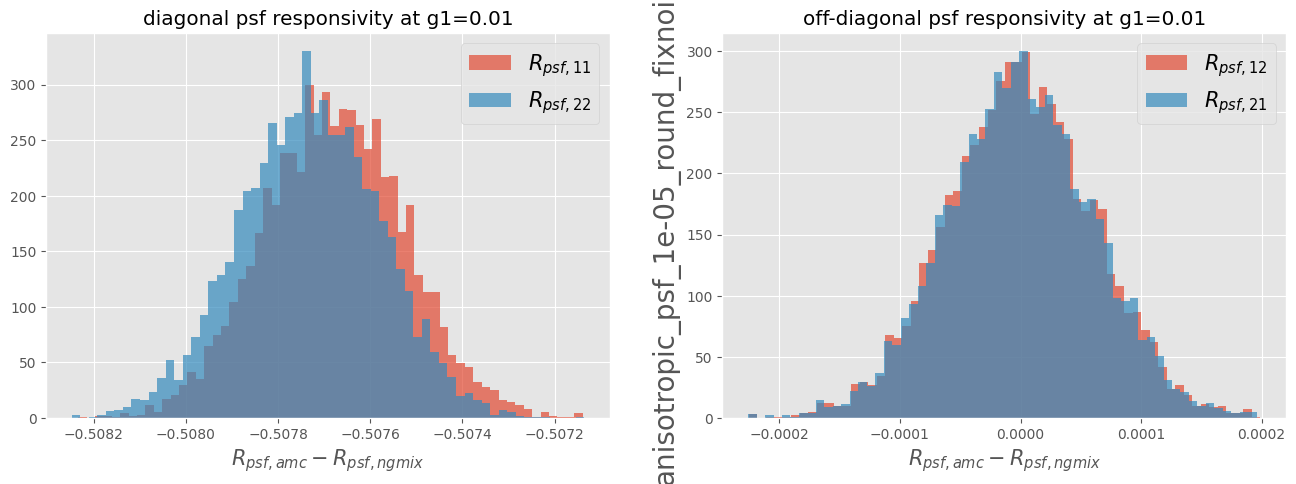

In [23]:
figure(figsize=(16,5))
subplot(121)
hist((Rpsf_amc - Rpsf_ngmix)[:,0,0].numpy().flatten(),alpha=0.7,bins=60, label='$R_{psf,11}$');
hist((Rpsf_amc - Rpsf_ngmix)[:,1,1].numpy().flatten(),alpha=0.7,bins=60, label='$R_{psf,22}$');
legend(fontsize=15)
xlabel('$R_{psf,amc} - R_{psf,ngmix}$',fontsize=15)
title(f'diagonal psf responsivity at g1={shear}')
subplot(122)
ylabel(settings_name,fontsize=20)
hist((Rpsf_amc - Rpsf_ngmix)[:,0,1].numpy().flatten(),alpha=0.7,bins=60, label='$R_{psf,12}$');
hist((Rpsf_amc - Rpsf_ngmix)[:,1,0].numpy().flatten(),alpha=0.7,bins=60, label='$R_{psf,21}$');
legend(fontsize=15)
xlabel('$R_{psf,amc} - R_{psf,ngmix}$',fontsize=15)
title(f'off-diagonal psf responsivity at g1={shear}')
savefig(f'Rpsf_{settings_name}.jpg',bbox_inches='tight')

In [24]:
(Rpsf_amc - Rpsf_ngmix)[:,0,0].numpy().flatten().mean()

-0.5076775

In [25]:
(Rpsf_amc - Rpsf_ngmix)[:,0,0].numpy().flatten().std()

0.00015218453

In [26]:
(Rpsf_amc - Rpsf_ngmix)[:,1,1].numpy().flatten().mean()

-0.5077303

In [27]:
(Rpsf_amc - Rpsf_ngmix)[:,1,1].numpy().flatten().std()

0.00015116563

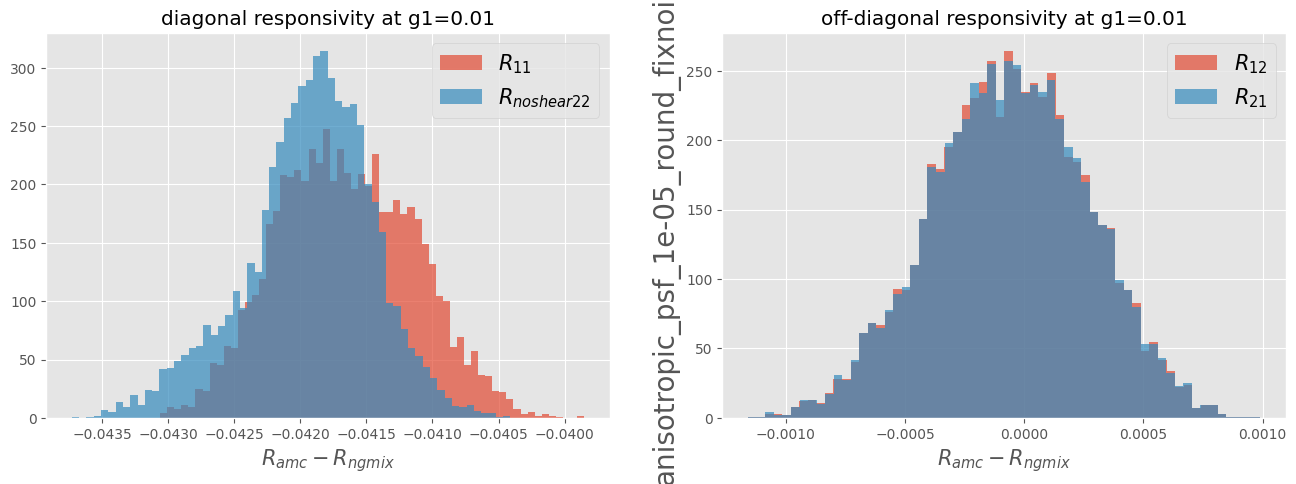

In [28]:
figure(figsize=(16,5))
subplot(121)
hist((R_amc - R_ngmix)[:,0,0].numpy().flatten(),alpha=0.7,bins=60, label='$R_{11}$');
hist((R_amc - R_ngmix)[:,1,1].numpy().flatten(),alpha=0.7,bins=60, label='$R_{noshear22}$');
legend(fontsize=15)
xlabel('$R_{amc} - R_{ngmix}$',fontsize=15)
title(f'diagonal responsivity at g1={shear}')
subplot(122)
ylabel(settings_name,fontsize=20)
hist((R_amc - R_ngmix)[:,0,1].numpy().flatten(),alpha=0.7,bins=60, label='$R_{12}$');
hist((R_amc - R_ngmix)[:,1,0].numpy().flatten(),alpha=0.7,bins=60, label='$R_{21}$');
legend(fontsize=15)
xlabel('$R_{amc} - R_{ngmix}$',fontsize=15)
title(f'off-diagonal responsivity at g1={shear}')
savefig(f'R_{settings_name}.jpg',bbox_inches='tight')

## Sensitivity Tests

In [29]:
def test_loop(noise_level,fieldbatches=5):
  shear_range = linspace(-.01,.01,4)

  shear_ngmix_list = []
  shear_err_ngmix_list = []
  shearcorr_ngmix_list = []
  shearcorr_err_ngmix_list = []
  R_ngmix_list = []
  Rpsf_ngmix_list = []

  shear_amc_list = []
  shear_err_amc_list = []
  shearcorr_amc_list = []
  shearcorr_err_amc_list = []
  R_amc_list = []
  Rpsf_amc_list = []
    
  for shear in shear_range:
    shear_true = array([shear,0.],dtype='float32')
    result = run_field(shear_true,g_psf,noise_level,fieldbatches)
    #ngmix
    shear_ngmix_list += [result['ngmix']['shear'] ] 
    shear_err_ngmix_list += [result['ngmix']['shear_err']]
    shearcorr_ngmix_list += [result['ngmix']['shearcorr']]
    shearcorr_err_ngmix_list += [result['ngmix']['shearcorr_err']]
    R_ngmix_list += [result['ngmix']['R']]
    Rpsf_ngmix_list += [result['ngmix']['Rpsf']]
    #amc   
    shear_amc_list += [result['amc']['shear']]
    shear_err_amc_list += [result['amc']['shear_err']]
    shearcorr_amc_list += [result['amc']['shearcorr']]
    shearcorr_err_amc_list += [result['amc']['shearcorr_err']]
    R_amc_list += [result['amc']['R']]
    Rpsf_amc_list += [result['amc']['Rpsf']]
  
  #g1
  #ngmix
  X1 = shear_range#[:,0]
  Y1_ngmix =  array(shearcorr_ngmix_list)[:,0]
  Y1err_ngmix = array(shearcorr_err_ngmix_list)[:,0]
  g1_scatter_ngmix = Y1err_ngmix.mean()

  #biases
  ngmix_bias1 = linregress(X1,Y1_ngmix)
  m1_ngmix = ngmix_bias1.slope - 1
  c1_ngmix = ngmix_bias1.intercept

  #errors
  m1_ngmix_err = ngmix_bias1.stderr
  c1_ngmix_err = ngmix_bias1.intercept_stderr
  
  #amc
  Y1_amc =  array(shearcorr_amc_list)[:,0] 
  Y1err_amc = array(shearcorr_err_amc_list)[:,0]
  g1_scatter_amc = Y1err_amc.mean()

  #biases
  amc_bias1 = linregress(X1,Y1_amc)
  m1_amc = amc_bias1.slope - 1
  c1_amc = amc_bias1.intercept

  #errors
  m1_amc_err = amc_bias1.stderr
  c1_amc_err = amc_bias1.intercept_stderr
  
  #g2
  X2 = shear_range#[:,1]
  Y2_ngmix =  array(shearcorr_ngmix_list)[:,1]
  Y2err_ngmix = array(shearcorr_err_ngmix_list)[:,1]
  g2_scatter_ngmix = Y2err_ngmix.mean()

  #biases
  ngmix_bias2 = linregress(X2,Y2_ngmix)
  m2_ngmix = ngmix_bias2.slope - 1
  c2_ngmix = ngmix_bias2.intercept

  #errors
  m2_ngmix_err = ngmix_bias.stderr
  c2_ngmix_err = ngmix_bias.intercept_stderr
  
  Y2_amc =  array(shearcorr_amc_list)[:,1] 
  Y2err_amc = array(shearcorr_err_amc_list)[:,0]

  #biases
  amc_bias2 = linregress(X2,Y2_amc)
  m2_amc = amc_bias2.slope-1
  c2_amc = amc_bias2.intercept

  #errors
  m2_amc_err = amc_bias.stderr
  c2_amc_err = amc_bias.intercept_stderr
  
  result = {
    'm1_amc' :[m1_amc,m1_amc_err],
    'c1_amc' :[c1_amc,c1_amc_err], 
    'm1_ngmix' :[m1_ngmix,m1_ngmix_err],
    'c1_ngmix' :[c1_ngmix,c1_ngmix_err],
    'g1_scatter_amc' : g1_scatter_amc,
    'g1_scatter_ngmix' : g1_scatter_ngmix,
    'm2_amc' :[m2_amc,m2_amc_err],
    'c2_amc' :[c2_amc,c2_amc_err],
    'm2_ngmix' :[m2_ngmix,m2_ngmix_err], 
    'c2_ngmix' :[c2_ngmix,c2_ngmix_err],
    #'g2_scatter_amc' : g2_scatter_amc,
    #'g2_scatter_ngmix' : g2_scatter_ngmix,
  }
  
  return result

In [30]:
test_result_list = []
timestamp = time.time()
noises=logspace(-2,-3,6)
for noise_level in tqdm.tqdm(noises):
  test_result_list +=[test_loop(noise_level,fieldbatches=5)]
  save(f"sensetest_{settings_name}_{timestamp}.npy",test_result_list)
  

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [10:21<00:00, 103.52s/it]


In [31]:
#get bias
m1_amc_list = [test_result['m1_amc'][0] for test_result in test_result_list]
m1_ngmix_list = [test_result['m1_ngmix'][0] for test_result in test_result_list]

c1_amc_list = [test_result['c1_amc'][0] for test_result in test_result_list]
c1_ngmix_list = [test_result['c1_ngmix'][0] for test_result in test_result_list]

#get bias errors
m1_amc_err_list = [test_result['m1_amc'][1] for test_result in test_result_list]
m1_ngmix_err_list = [test_result['m1_ngmix'][1] for test_result in test_result_list]

c1_amc_err_list = [test_result['c1_amc'][1] for test_result in test_result_list]
c1_ngmix_err_list = [test_result['c1_ngmix'][1] for test_result in test_result_list]

#get shear estimates
g1_scatter_amc_list = [test_result['g1_scatter_amc'] for test_result in test_result_list]
g1_scatter_ngmix_list = [test_result['g1_scatter_ngmix'] for test_result in test_result_list]

In [32]:
def plotcontour(X,Y,Ym,Yp,label,color):
  fill_between(X,array(Y)-array(Ym),array(Y)+array(Ym),color=color,alpha=.1)
  plot(X,Y,color=color,label=label)

In [33]:
X = 1/sqrt(noises) #~snr

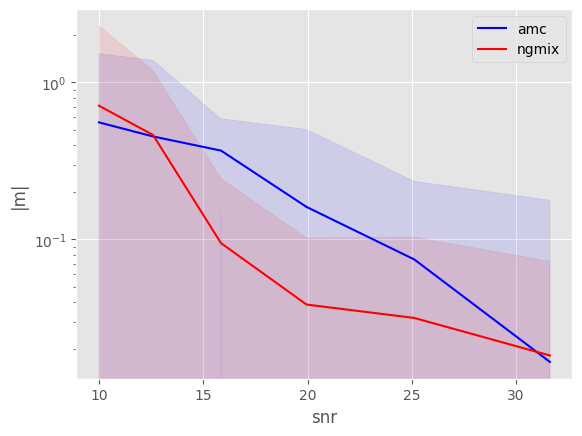

In [37]:
Y1 = abs(array(m1_amc_list))
Y1e= m1_amc_err_list

Y2 = abs(array(m1_ngmix_list))
Y2e= m1_ngmix_err_list

plotcontour(X,Y1,Y1e,Y1e,'amc','b')
plotcontour(X,Y2,Y2e,Y2e,'ngmix','r')
yscale('log')
xlabel('snr')
ylabel('|m|')
legend()
savefig('sensitivity_m1.jpeg')

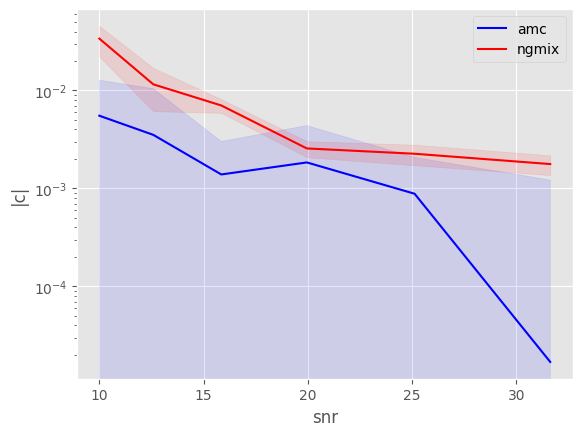

In [35]:
Y1 = abs(array(c1_amc_list))
Y1e= c1_amc_err_list

Y2 = abs(array(c1_ngmix_list))
Y2e= c1_ngmix_err_list

plotcontour(X,Y1,Y1e,Y1e,'amc','b')
plotcontour(X,Y2,Y2e,Y2e,'ngmix','r')
yscale('log')
xlabel('snr')
ylabel('|c|')
legend()
savefig('sensitivity_c1.jpeg')

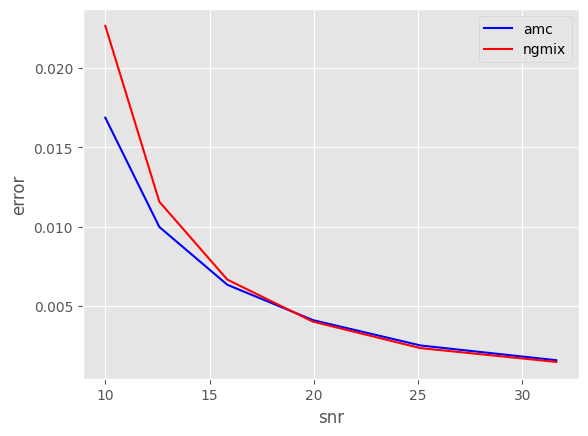

In [36]:
Y1 = g1_scatter_amc_list
Y2 = g1_scatter_ngmix_list


plot(X,Y1,'b',label='amc')
plot(X,Y2,'r',label='ngmix')

xlabel('snr')
ylabel('error')
legend()
savefig('sensitivity_scatter.jpeg')